# Explore the psf.cat files 

In [1]:
import astropy
from astropy.io import fits

# Open the FITS file and examine its structure
with fits.open('DRACO_DWARF/reduced_new/20251017135-101-RA.wcs.proc.fits.cat') as hdul:
    print("FITS File Structure:")
    print("=" * 50)
    
    # Print basic file info
    print(f"Number of HDUs (extensions): {len(hdul)}")
    print()
    
    # Print information about each HDU
    for i, hdu in enumerate(hdul):
        print(f"HDU {i}: {type(hdu).__name__}")
        print(f"  Name: {hdu.name}")
        print(f"  Shape: {hdu.shape if hasattr(hdu, 'shape') else 'N/A'}")
        
        if hasattr(hdu, 'data') and hdu.data is not None:
            print(f"  Data type: {type(hdu.data)}")
            if hasattr(hdu.data, 'shape'):
                print(f"  Data shape: {hdu.data.shape}")
        
        # Print some key header keywords
        if hasattr(hdu, 'header'):
            print("  Key header keywords:")
            for key in ['EXTNAME', 'NAXIS', 'NAXIS1', 'NAXIS2', 'TFIELDS', 'TTYPE1', 'TTYPE2']:
                if key in hdu.header:
                    print(f"    {key}: {hdu.header[key]}")
        
        print()
    
    # Print detailed information about the main data extension
    if len(hdul) > 1:
        main_hdu = hdul[1]  # Usually the second HDU contains the main data
        if hasattr(main_hdu, 'data') and main_hdu.data is not None:
            print("Main Data Extension Details:")
            print("=" * 30)
            print(f"Number of sources: {len(main_hdu.data)}")
            print(f"Number of columns: {len(main_hdu.data.dtype.names)}")
            """
            print("\nColumn names and types:")
            for i, (name, dtype) in enumerate(zip(main_hdu.data.dtype.names, main_hdu.data.dtype)):
                print(f"  {i+1:2d}. {name:20s} ({dtype})")
            """

    # Print detailed information about the main data extension
    if len(hdul) > 2:
        hdu = hdul[2]  # Usually the second HDU contains the main data
        if hasattr(hdu, 'data') and hdu.data is not None:
            print("Data Extension Details:")
            print("=" * 30)
            print(f"Number of sources: {len(hdu.data)}")
            print(f"Number of columns: {len(hdu.data.dtype.names)}")
            print("\nColumn names and types:")
            for i, (name) in enumerate(hdu.data.dtype.names):
                print(f"  {i+1:2d}. {name:20s})")
            



FITS File Structure:
Number of HDUs (extensions): 3

HDU 0: PrimaryHDU
  Name: PRIMARY
  Shape: ()
  Key header keywords:
    NAXIS: 0

HDU 1: BinTableHDU
  Name: LDAC_IMHEAD
  Shape: N/A
  Data type: <class 'astropy.io.fits.fitsrec.FITS_rec'>
  Data shape: (1,)
  Key header keywords:
    EXTNAME: LDAC_IMHEAD
    NAXIS: 2
    NAXIS1: 20000
    NAXIS2: 1
    TFIELDS: 1
    TTYPE1: Field Header Card

HDU 2: BinTableHDU
  Name: LDAC_OBJECTS
  Shape: N/A
  Data type: <class 'astropy.io.fits.fitsrec.FITS_rec'>
  Data shape: (664,)
  Key header keywords:
    EXTNAME: LDAC_OBJECTS
    NAXIS: 2
    NAXIS1: 34
    NAXIS2: 664
    TFIELDS: 9
    TTYPE1: X_IMAGE
    TTYPE2: Y_IMAGE

Main Data Extension Details:
Number of sources: 1
Number of columns: 1
Data Extension Details:
Number of sources: 664
Number of columns: 9

Column names and types:
   1. X_IMAGE             )
   2. Y_IMAGE             )
   3. MAG_AUTO            )
   4. MAG_PSF             )
   5. MAGERR_PSF          )
   6. FLUX_PSF 

In [ ]:
import os
import pandas as pd
from astropy.io import fits
import numpy as np

# Define paths
input_dir = "DRACO_DWARF/reduced_new"
output_dir = "output_new"
    
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)
    
# Find all .psf.cat files
psf_files = []
for file in os.listdir(input_dir):
    if file.endswith('.cat'):
        psf_files.append(os.path.join(input_dir, file))
    
print(f"Found {len(psf_files)} .cat files")
    
all_data = []
    
for psf_file in psf_files:
    obs_identifier = os.path.basename(psf_file)[:15]
    print(f"Processing: {os.path.basename(psf_file)}:{obs_identifier}")
        
    try:
        psf_zp = 0
        filter = None
        orig_fits_file = psf_file.replace('.cat', '')
        # Read the PSF_ZP header from the original FITS file
        with fits.open(orig_fits_file) as hdul:
            psf_zp = hdul[0].header.get('PSF_ZP')
            filter = hdul[0].header.get('FILTER')
            print(f"PSF_ZP value: {psf_zp}, FILTER= {filter}")
                    
        # Read the FITS file
        with fits.open(psf_file) as hdul:# Get the main data extension (HDU 2)
            catalog_data = hdul[2].data
    
            # Create a dictionary to store the data, handling multi-dimensional arrays
            data_dict = {}
            
            # Process each column
            for col_name in catalog_data.dtype.names:
                col_data = catalog_data[col_name]
                
                # Check if the column contains multi-dimensional arrays
                if col_data.ndim > 1:
                    # For multi-dimensional arrays (like VIGNET), we'll skip them for CSV
                    #print(f"Skipping column '{col_name}' - contains multi-dimensional data (shape: {col_data.shape})")
                    continue
                else:
                    # For 1D arrays, add to our data dictionary
                    data_dict[col_name] = col_data
            
            # Convert to pandas DataFrame
            df = pd.DataFrame(data_dict)
            df['FILTER'] = filter
            df['PSF_ZP'] = psf_zp
            df['OBS_IDENTIFIER'] = obs_identifier
            # Display basic info about the DataFrame
            #print(f"DataFrame shape: {df.shape}")
            #print(f"Columns: {list(df.columns)}")
            #print(f"\nFirst few rows:")
            #print(df.head())
            
            # Write to CSV file
            output_filename = psf_file.replace('.psf.cat', '.catalog.csv').replace('DRACO_DWARF/reduced', 'output')
            df.to_csv(output_filename, index=False)
            
            print(f"\nCatalog data written to: {output_filename}")
            #print(f"Total sources: {len(df)}")
            #print(f"Total columns: {len(df.columns)}")
    except Exception as e:
        print(f"  - Error processing {psf_file}: {str(e)}")


Found 12 .cat files
Processing: 20251017142-734-RA.wcs.proc.fits.cat:20251017142-734
PSF_ZP value: 25.43501672286987, FILTER= i

Catalog data written to: output_new/20251017142-734-RA.wcs.proc.fits.cat
Processing: 20251017135-812-RA.wcs.proc.fits.cat:20251017135-812
PSF_ZP value: 25.39295352783203, FILTER= i

Catalog data written to: output_new/20251017135-812-RA.wcs.proc.fits.cat
Processing: 20251017150-403-RA.wcs.proc.fits.cat:20251017150-403
PSF_ZP value: 26.504264575195315, FILTER= g

Catalog data written to: output_new/20251017150-403-RA.wcs.proc.fits.cat
Processing: 20251017141-300-RA.wcs.proc.fits.cat:20251017141-300
PSF_ZP value: 25.29357479324341, FILTER= i

Catalog data written to: output_new/20251017141-300-RA.wcs.proc.fits.cat
Processing: 20251017142-022-RA.wcs.proc.fits.cat:20251017142-022
PSF_ZP value: 26.53699850463867, FILTER= g

Catalog data written to: output_new/20251017142-022-RA.wcs.proc.fits.cat
Processing: 20251017135-101-RA.wcs.proc.fits.cat:20251017135-101
PSF_

In [5]:
import pandas as pd
import numpy as np
import os

# Define the g-band to i-band mapping
g_to_i = {
    '20251017135-101': '20251017135-812',
    '20251017140-542': '20251017141-300',
    '20251017142-022': '20251017142-734',
    '20251017143-456': '20251017144-208',
    '20251017144-929': '20251017145-642',
    '20251017150-403': '20251017151-115'
}

# Create output directory if it doesn't exist
output_dir = "output_new"
os.makedirs(output_dir, exist_ok=True)

# Initialize list to store all matched data
all_matches = []

# Process each g-band to i-band pair
for g_key, i_key in g_to_i.items():
    print(f"Processing pair: {g_key} (g-band) -> {i_key} (i-band)")
    
    try:
        # Load g-band CSV file
        g_file = f"output/{g_key}-RA.wcs.proc.fits.catalog.csv"
        g_df = pd.read_csv(g_file)
        
        # Load i-band CSV file  
        i_file = f"output/{i_key}-RA.wcs.proc.fits.catalog.csv"
        i_df = pd.read_csv(i_file)
        
        # Select only the required columns
        required_cols = ['ALPHAWIN_J2000', 'DELTAWIN_J2000', 'MAG_POINTSOURCE', 'MAGERR_POINTSOURCE', 'PSF_ZP']
        
        g_df_subset = g_df[required_cols].copy()
        i_df_subset = i_df[required_cols].copy()
        
        print(f"G-band sources: {len(g_df_subset)}")
        print(f"I-band sources: {len(i_df_subset)}")
        
        # Calculate coordinate ranges for normalization
        alpha_range = (g_df_subset['ALPHAWIN_J2000'].max() - g_df_subset['ALPHAWIN_J2000'].min() + 
                      i_df_subset['ALPHAWIN_J2000'].max() - i_df_subset['ALPHAWIN_J2000'].min())
        delta_range = (g_df_subset['DELTAWIN_J2000'].max() - g_df_subset['DELTAWIN_J2000'].min() + 
                      i_df_subset['DELTAWIN_J2000'].max() - i_df_subset['DELTAWIN_J2000'].min())
        
        # Create a copy of i_df_subset for tracking remaining records
        i_df_remaining = i_df_subset.copy()
        
        # For each record in g-band, find the best match in i-band
        MAX_MATCH_DISTANCE = 1e-3
        
        for g_idx, g_row in g_df_subset.iterrows():
            g_ra = g_row['ALPHAWIN_J2000']
            g_dec = g_row['DELTAWIN_J2000']
            
            if len(i_df_remaining) == 0:
                break
            
            # Calculate distances for all remaining i-band sources
            distances = np.sqrt(
                ((i_df_remaining['ALPHAWIN_J2000'] - g_ra)/alpha_range)**2 + 
                ((i_df_remaining['DELTAWIN_J2000'] - g_dec)/delta_range)**2
            )
            
            # Find the index of the closest match
            best_i_idx = distances.idxmin()
            best_distance = distances.min()
            
            if best_distance < MAX_MATCH_DISTANCE:
                # Get the best matching i-band record
                i_row = i_df_remaining.loc[best_i_idx]
                
                # Calculate magnitudes and color
                g_mag = g_row['MAG_POINTSOURCE'] + g_row['PSF_ZP']
                i_mag = i_row['MAG_POINTSOURCE'] + i_row['PSF_ZP']
                color = g_mag - i_mag
                mag_err = g_row['MAGERR_POINTSOURCE'] + i_row['MAGERR_POINTSOURCE']
                
                # Calculate average coordinates
                ra = 0.5 * (g_row['ALPHAWIN_J2000'] + i_row['ALPHAWIN_J2000'])
                dec = 0.5 * (g_row['DELTAWIN_J2000'] + i_row['DELTAWIN_J2000'])
                
                # Store the match
                all_matches.append({
                    'g_key': g_key,
                    'i_key': i_key,
                    'ra': ra,
                    'dec': dec,
                    'g_mag': g_mag,
                    'i_mag': i_mag,
                    'color': color,
                    'mag_err': mag_err,
                    'match_distance': best_distance,
                })
                
                # Remove the matched record from remaining i-band sources
                i_df_remaining = i_df_remaining.drop(best_i_idx)
        
        print(f"Matches found: {len([m for m in all_matches if m['g_key'] == g_key])}")
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
    except Exception as e:
        print(f"Error processing {g_key} -> {i_key}: {e}")

# Create DataFrame from all matches
if all_matches:
    color_mag_df = pd.DataFrame(all_matches)
    
    # Save to CSV
    output_file = "output/color_mag.csv"
    color_mag_df.to_csv(output_file, index=False)
    
    print(f"\nConsolidated color_mag.csv created with {len(color_mag_df)} sources")
    print(f"File saved to: {output_file}")
    print(f"\nColumns: {list(color_mag_df.columns)}")
    print(f"\nFirst few rows:")
    print(color_mag_df.head())
else:
    print("No matches found to create consolidated file")

Processing pair: 20251017135-101 (g-band) -> 20251017135-812 (i-band)
G-band sources: 46
I-band sources: 47
Matches found: 45
Processing pair: 20251017140-542 (g-band) -> 20251017141-300 (i-band)
G-band sources: 39
I-band sources: 41
Matches found: 34
Processing pair: 20251017142-022 (g-band) -> 20251017142-734 (i-band)
G-band sources: 48
I-band sources: 52
Matches found: 45
Processing pair: 20251017143-456 (g-band) -> 20251017144-208 (i-band)
G-band sources: 52
I-band sources: 53
Matches found: 45
Processing pair: 20251017144-929 (g-band) -> 20251017145-642 (i-band)
G-band sources: 38
I-band sources: 46
Matches found: 36
Processing pair: 20251017150-403 (g-band) -> 20251017151-115 (i-band)
G-band sources: 38
I-band sources: 40
Matches found: 34

Consolidated color_mag.csv created with 239 sources
File saved to: output/color_mag.csv

Columns: ['g_key', 'i_key', 'ra', 'dec', 'g_mag', 'i_mag', 'color', 'mag_err', 'match_distance']

First few rows:
             g_key            i_key     

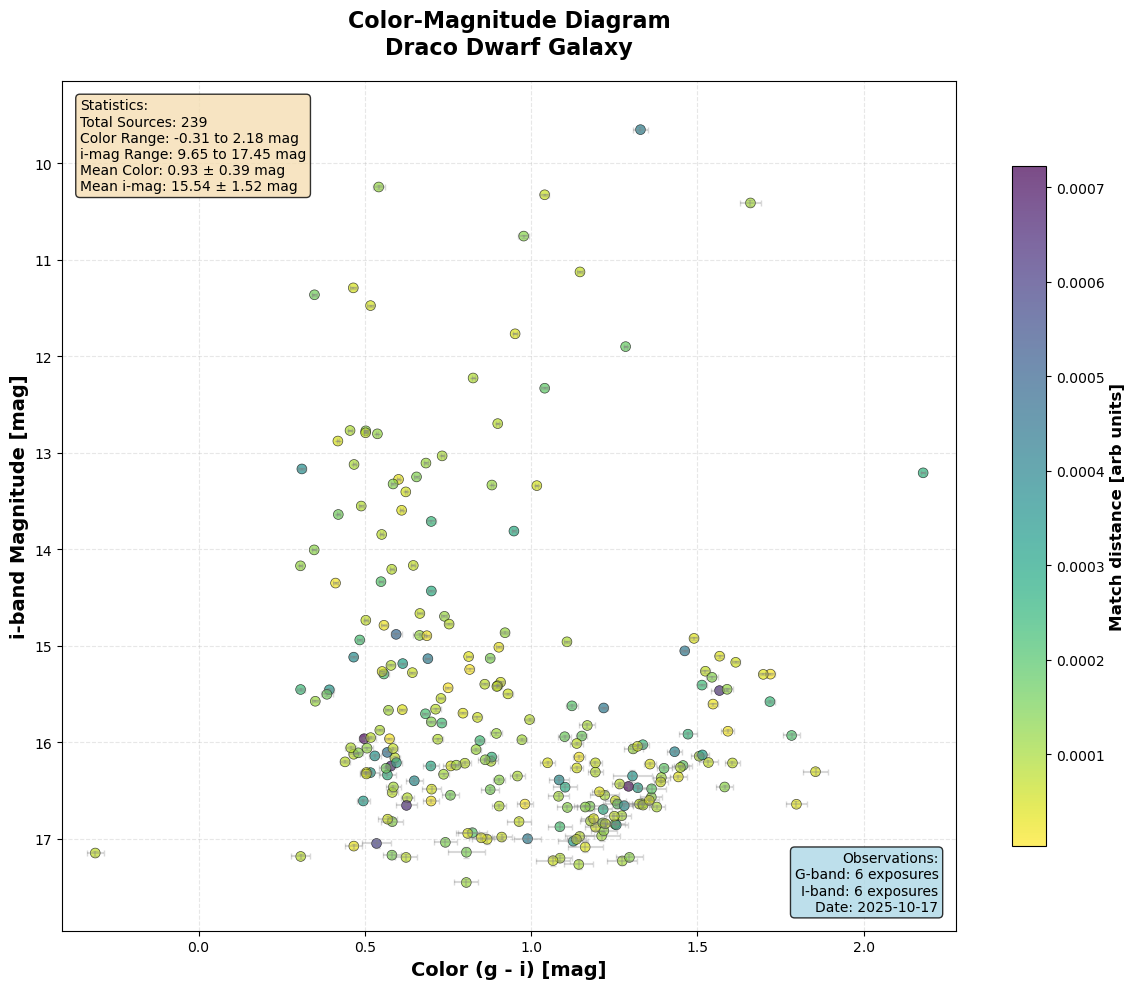

Color-Magnitude Diagram Summary:
Total sources: 239
Color range: -0.310 to 2.179 mag
i-magnitude range: 9.653 to 17.452 mag
Mean color: 0.932 ± 0.389 mag
Mean i-magnitude: 15.540 ± 1.524 mag
Mean magnitude error: 0.020 mag


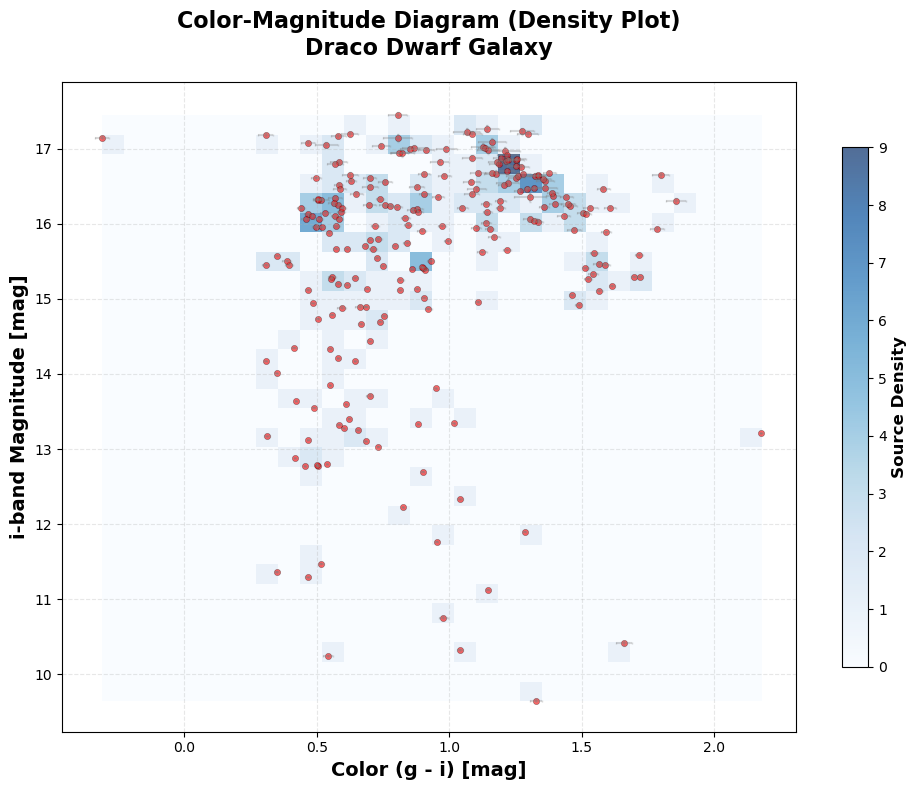

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Load the color-magnitude data
df = pd.read_csv('output/color_mag.csv')

# Create a professional color-magnitude diagram
fig, ax = plt.subplots(figsize=(12, 10))

# Set up the plot with proper astronomical conventions
# In astronomy, magnitude increases downward (fainter objects are higher numbers)
# So we'll invert the y-axis

# Create scatter plot with error bars
scatter = ax.scatter(df['color'], df['i_mag'], 
                    c=df['match_distance'], 
                    s=50, 
                    alpha=0.7, 
                    cmap='viridis_r',
                    edgecolors='black',
                    linewidth=0.5)

# Add error bars
ax.errorbar(df['color'], df['i_mag'], 
           xerr=df['mag_err'], 
           yerr=df['mag_err'],
           fmt='none', 
           alpha=0.3, 
           color='gray',
           capsize=2)

# Customize the plot
ax.set_xlabel('Color (g - i) [mag]', fontsize=14, fontweight='bold')
ax.set_ylabel('i-band Magnitude [mag]', fontsize=14, fontweight='bold')
ax.set_title('Color-Magnitude Diagram\nDraco Dwarf Galaxy', fontsize=16, fontweight='bold', pad=20)

# Invert y-axis (astronomical convention: brighter = lower magnitude)
ax.invert_yaxis()

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Set axis limits with some padding
ax.set_xlim(df['color'].min() - 0.1, df['color'].max() + 0.1)
ax.set_ylim(df['i_mag'].max() + 0.5, df['i_mag'].min() - 0.5)

# Add colorbar for magnitude errors
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Match distance [arb units]', fontsize=12, fontweight='bold')

# Add statistics text box
stats_text = f"""Statistics:
Total Sources: {len(df)}
Color Range: {df['color'].min():.2f} to {df['color'].max():.2f} mag
i-mag Range: {df['i_mag'].min():.2f} to {df['i_mag'].max():.2f} mag
Mean Color: {df['color'].mean():.2f} ± {df['color'].std():.2f} mag
Mean i-mag: {df['i_mag'].mean():.2f} ± {df['i_mag'].std():.2f} mag"""

# Add text box with statistics
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Add observation details
obs_text = f"""Observations:
G-band: {df['g_key'].nunique()} exposures
I-band: {df['i_key'].nunique()} exposures
Date: 2025-10-17"""

ax.text(0.98, 0.02, obs_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('output/color_magnitude_diagram.png', dpi=300, bbox_inches='tight')
plt.savefig('output/color_magnitude_diagram.pdf', bbox_inches='tight')

# Show the plot
plt.show()

# Print summary statistics
print("Color-Magnitude Diagram Summary:")
print("=" * 50)
print(f"Total sources: {len(df)}")
print(f"Color range: {df['color'].min():.3f} to {df['color'].max():.3f} mag")
print(f"i-magnitude range: {df['i_mag'].min():.3f} to {df['i_mag'].max():.3f} mag")
print(f"Mean color: {df['color'].mean():.3f} ± {df['color'].std():.3f} mag")
print(f"Mean i-magnitude: {df['i_mag'].mean():.3f} ± {df['i_mag'].std():.3f} mag")
print(f"Mean magnitude error: {df['mag_err'].mean():.3f} mag")

# Create a second plot focusing on the main sequence/red giant branch
fig2, ax2 = plt.subplots(figsize=(10, 8))

# Create a 2D histogram for better visualization of density
H, xedges, yedges = np.histogram2d(df['color'], df['i_mag'], bins=30)
extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]  # Note: yedges inverted for astronomical convention

# Plot 2D histogram
im = ax2.imshow(H.T, extent=extent, aspect='auto', cmap='Blues', alpha=0.7)

# Overlay scatter plot
ax2.scatter(df['color'], df['i_mag'], 
           c='red', s=20, alpha=0.6, edgecolors='black', linewidth=0.3)

# Add error bars
ax2.errorbar(df['color'], df['i_mag'], 
            xerr=df['mag_err'], 
            yerr=df['mag_err'],
            fmt='none', alpha=0.3, color='gray', capsize=1)

ax2.set_xlabel('Color (g - i) [mag]', fontsize=14, fontweight='bold')
ax2.set_ylabel('i-band Magnitude [mag]', fontsize=14, fontweight='bold')
ax2.set_title('Color-Magnitude Diagram (Density Plot)\nDraco Dwarf Galaxy', 
              fontsize=16, fontweight='bold', pad=20)

# Invert y-axis
ax2.invert_yaxis()

# Add grid
ax2.grid(True, alpha=0.3, linestyle='--')

# Add colorbar for density
cbar2 = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar2.set_label('Source Density', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('output/color_magnitude_density.png', dpi=300, bbox_inches='tight')
plt.savefig('output/color_magnitude_density.pdf', bbox_inches='tight')
plt.show()

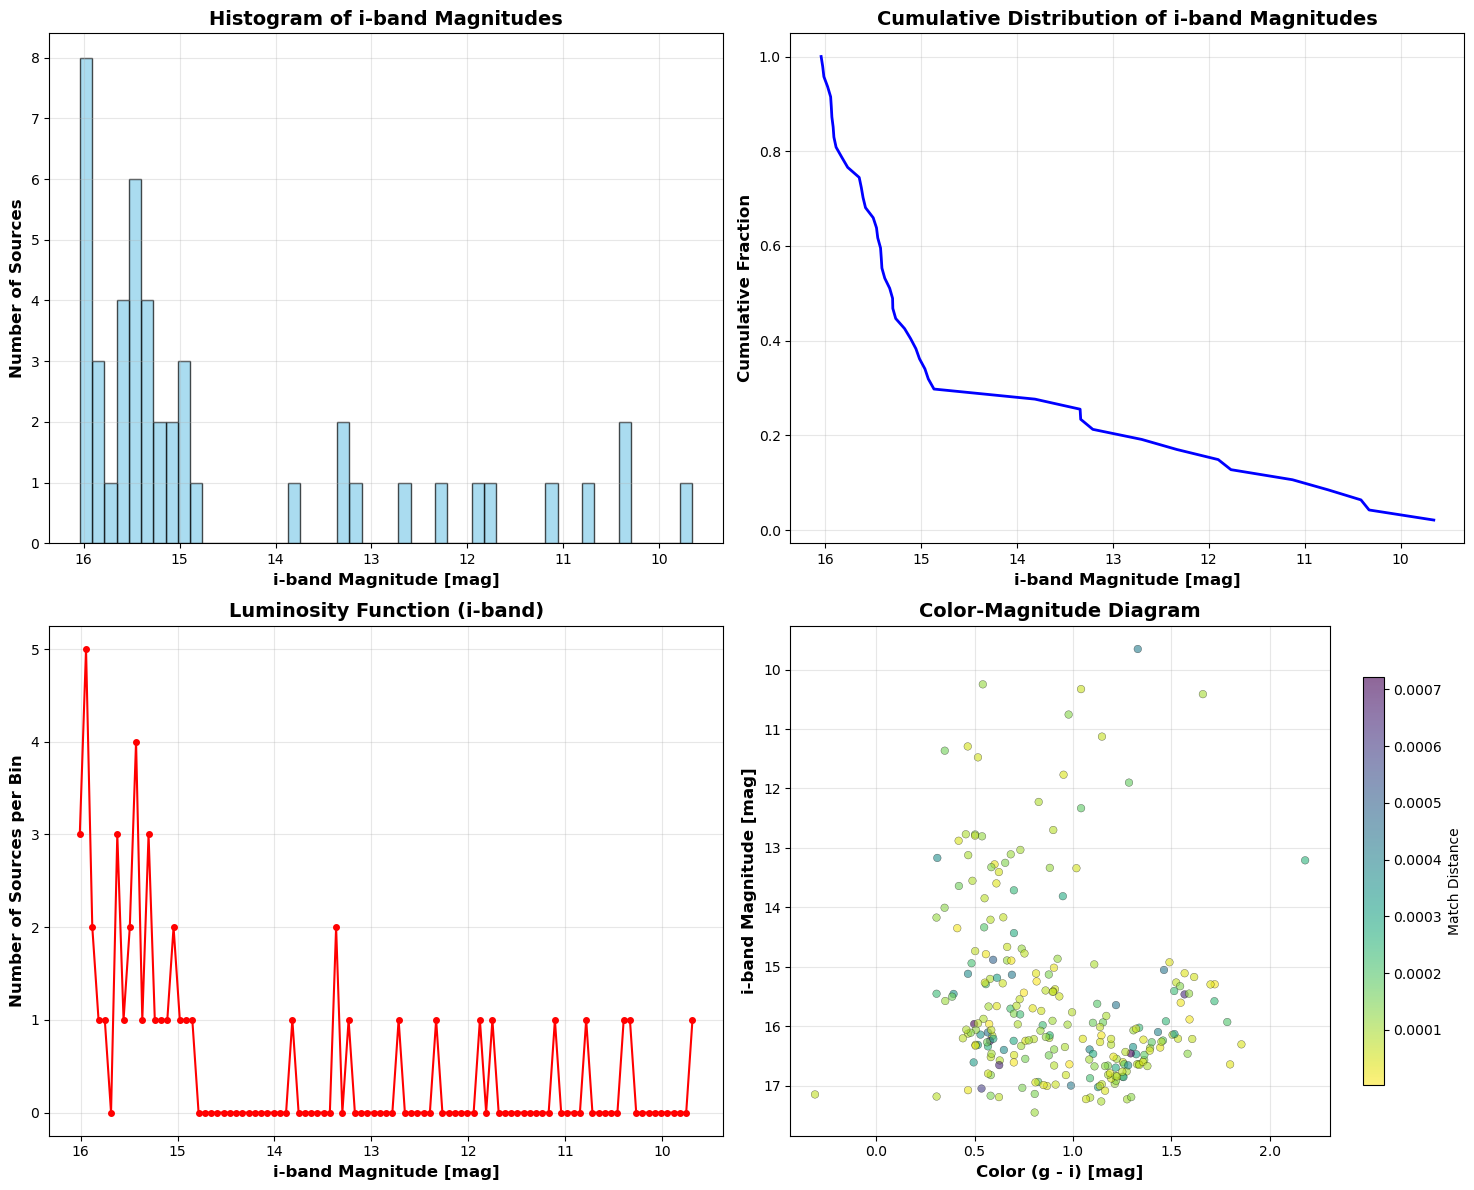

TRGB (Tip of the Red Giant Branch) ANALYSIS
Number of peaks found: 1
Peak magnitudes and heights:
  Peak 1: 15.429 mag (height: 2.0)

Statistical Analysis:
Total sources: 239
i-magnitude range: 9.653 to 17.452 mag
Mean i-magnitude: 15.540 ± 1.524 mag
Median i-magnitude: 16.065 mag

Top 5 TRGB Candidates (from cumulative distribution):
  1. Magnitude: 16.153 mag, Derivative: 150.00 (index: 32)
  2. Magnitude: 16.553 mag, Derivative: 125.00 (index: 34)
  3. Magnitude: 16.353 mag, Derivative: 100.00 (index: 33)
  4. Magnitude: 16.753 mag, Derivative: 90.00 (index: 35)
  5. Magnitude: 16.953 mag, Derivative: 80.00 (index: 36)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.signal import find_peaks

# Load the color-magnitude data
df = pd.read_csv('output/color_mag.csv')
# TRGB stars are typically red giants, so look for red sources
# Compute the 50th percentile (top 50%) color and magnitude thresholds, ignoring NaN/inf
color_clean = df['color'].replace([np.inf, -np.inf], np.nan).dropna()
color_cutoff = color_clean.quantile(0.50)
imag_clean = df['i_mag'].replace([np.inf, -np.inf], np.nan).dropna()
imag_cutoff = imag_clean.quantile(0.50)

# Select red giants as the top 20% in color
red_sources = df[(df['color'] >= color_cutoff) & (df['i_mag'] <= imag_cutoff)]

#df = red_sources
# Create a comprehensive histogram analysis for TRGB detection
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Basic histogram of i-band magnitudes
ax1 = axes[0, 0]
n, bins, patches = ax1.hist(red_sources['i_mag'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('i-band Magnitude [mag]', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Sources', fontsize=12, fontweight='bold')
ax1.set_title('Histogram of i-band Magnitudes', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()  # Invert x-axis for astronomical convention (brighter = lower magnitude)

# 2. Cumulative distribution function
ax2 = axes[0, 1]
sorted_mags = np.sort(red_sources['i_mag'])
cumulative = np.arange(1, len(sorted_mags) + 1) / len(sorted_mags)
ax2.plot(sorted_mags, cumulative, 'b-', linewidth=2, label='Cumulative Distribution')
ax2.set_xlabel('i-band Magnitude [mag]', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Fraction', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Distribution of i-band Magnitudes', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

# 3. Luminosity function (density plot)
ax3 = axes[1, 0]
# Create a finer histogram for luminosity function
mag_bins = np.linspace(red_sources['i_mag'].min(), red_sources['i_mag'].max(), 100)
n_fine, bins_fine = np.histogram(red_sources['i_mag'], bins=mag_bins)
bin_centers = (bins_fine[:-1] + bins_fine[1:]) / 2


# Plot luminosity function
ax3.plot(bin_centers, n_fine, 'ro-', markersize=4, linewidth=1.5, label='Luminosity Function')
ax3.set_xlabel('i-band Magnitude [mag]', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Sources per Bin', fontsize=12, fontweight='bold')
ax3.set_title('Luminosity Function (i-band)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.invert_xaxis()


# 4. Color-magnitude diagram with TRGB candidates highlighted
ax4 = axes[1, 1]
# Create scatter plot
scatter = ax4.scatter(df['color'], df['i_mag'], 
                     c=df['match_distance'], 
                     s=30, 
                     alpha=0.6, 
                     cmap='viridis_r',
                     edgecolors='black',
                     linewidth=0.3)

ax4.set_xlabel('Color (g - i) [mag]', fontsize=12, fontweight='bold')
ax4.set_ylabel('i-band Magnitude [mag]', fontsize=12, fontweight='bold')
ax4.set_title('Color-Magnitude Diagram', fontsize=14, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4, shrink=0.8)
cbar.set_label('Match Distance', fontsize=10)

plt.tight_layout()
plt.savefig('output/i_band_histogram_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:

# TRGB Detection Analysis
print("=" * 60)
print("TRGB (Tip of the Red Giant Branch) ANALYSIS")
print("=" * 60)

# Method 1: Peak detection in luminosity function
# Smooth the luminosity function
from scipy.ndimage import gaussian_filter1d
smoothed_lf = gaussian_filter1d(n_fine, sigma=1.0)

# Find peaks in the luminosity function
peaks, properties = find_peaks(smoothed_lf, height=np.max(smoothed_lf)*0.1, distance=5)
peak_magnitudes = bin_centers[peaks]
peak_heights = smoothed_lf[peaks]

print(f"Number of peaks found: {len(peaks)}")
if len(peaks) > 0:
    print("Peak magnitudes and heights:")
    for i, (mag, height) in enumerate(zip(peak_magnitudes, peak_heights)):
        print(f"  Peak {i+1}: {mag:.3f} mag (height: {height:.1f})")


TRGB (Tip of the Red Giant Branch) ANALYSIS
Number of peaks found: 1
Peak magnitudes and heights:
  Peak 1: 15.429 mag (height: 2.0)

Statistical Analysis:
Total sources: 239
i-magnitude range: 9.653 to 17.452 mag
Mean i-magnitude: 15.540 ± 1.524 mag
Median i-magnitude: 16.065 mag

Top 5 TRGB Candidates (from cumulative distribution):
  1. Magnitude: 16.153 mag, Derivative: 150.00 (index: 32)
  2. Magnitude: 16.553 mag, Derivative: 125.00 (index: 34)
  3. Magnitude: 16.353 mag, Derivative: 100.00 (index: 33)
  4. Magnitude: 16.753 mag, Derivative: 90.00 (index: 35)
  5. Magnitude: 16.953 mag, Derivative: 80.00 (index: 36)


In [22]:

# Method 2: Statistical analysis of magnitude distribution
print(f"\nStatistical Analysis:")
print(f"Total sources: {len(df)}")
print(f"i-magnitude range: {df['i_mag'].min():.3f} to {df['i_mag'].max():.3f} mag")
print(f"Mean i-magnitude: {df['i_mag'].mean():.3f} ± {df['i_mag'].std():.3f} mag")
print(f"Median i-magnitude: {df['i_mag'].median():.3f} mag")

print(np.arange(df['i_mag'].min(), df['i_mag'].max(), 1))
# Method 3: Look for discontinuities in the cumulative distribution
# Calculate the derivative of the cumulative distribution
mag_steps = [1, 0.5, 0.2, 0.1]
for mag_step in mag_steps:
    mag_grid = np.arange(df['i_mag'].min(), df['i_mag'].max(), mag_step)
    #mag_grid_diff = -np.diff(10**(-mag_grid))
    cumulative_at_grid = np.array([np.sum(df['i_mag'] <= mag) for mag in mag_grid])
    derivative = np.diff(cumulative_at_grid) / mag_step # (mag_grid_diff)
    #for i in range(len(mag_grid)-1):
    #    print(f'{mag_grid[i]},{mag_grid_diff[i]},{cumulative_at_grid[i]},{derivative[i]}')

    # Find the top 5 maximum derivatives (steepest part of cumulative distribution)
    top_5_indices = np.argsort(derivative)[-5:][::-1]  # Get top 5 indices, sorted from highest to lowest
    top_5_derivatives = derivative[top_5_indices]
    trgb_1_magnitudes = mag_grid[top_5_indices] + 0.5 * mag_step

    print(f"\nTop 5 TRGB Candidates (from cumulative distribution):")
    for i, (idx, deriv, mag) in enumerate(zip(top_5_indices, top_5_derivatives, trgb_1_magnitudes), 1):
        print(f"  {i}. Magnitude: {mag:.3f} mag, Derivative: {deriv:.2f} (index: {idx})")



Statistical Analysis:
Total sources: 239
i-magnitude range: 9.653 to 17.452 mag
Mean i-magnitude: 15.540 ± 1.524 mag
Median i-magnitude: 16.065 mag
[ 9.65349072 10.65349072 11.65349072 12.65349072 13.65349072 14.65349072
 15.65349072 16.65349072]

Top 5 TRGB Candidates (from cumulative distribution):
  1. Magnitude: 16.153 mag, Derivative: 101.00 (index: 6)
  2. Magnitude: 15.153 mag, Derivative: 48.00 (index: 5)
  3. Magnitude: 13.153 mag, Derivative: 20.00 (index: 3)
  4. Magnitude: 14.153 mag, Derivative: 10.00 (index: 4)
  5. Magnitude: 11.153 mag, Derivative: 5.00 (index: 1)

Top 5 TRGB Candidates (from cumulative distribution):
  1. Magnitude: 16.403 mag, Derivative: 124.00 (index: 13)
  2. Magnitude: 15.903 mag, Derivative: 78.00 (index: 12)
  3. Magnitude: 16.903 mag, Derivative: 76.00 (index: 14)
  4. Magnitude: 15.403 mag, Derivative: 58.00 (index: 11)
  5. Magnitude: 14.903 mag, Derivative: 38.00 (index: 10)

Top 5 TRGB Candidates (from cumulative distribution):
  1. Magnit

In [24]:

# Method 2: Statistical analysis of magnitude distribution
print(f"\nStatistical Analysis of red sources:")
print(f"Total sources: {len(red_sources)}")
print(f"i-magnitude range: {red_sources['i_mag'].min():.3f} to {red_sources['i_mag'].max():.3f} mag")
print(f"Mean i-magnitude: {red_sources['i_mag'].mean():.3f} ± {red_sources['i_mag'].std():.3f} mag")
print(f"Median i-magnitude: {red_sources['i_mag'].median():.3f} mag")

# Method 3: Look for discontinuities in the cumulative distribution
# Calculate the derivative of the cumulative distribution
mag_steps = [1, 0.5, 0.25, 0.125]
for mag_step in mag_steps:
    mag_grid = np.arange(red_sources['i_mag'].min(), red_sources['i_mag'].max(), mag_step)
    #mag_grid_diff = -np.diff(10**(-mag_grid))
    cumulative_at_grid = np.array([np.sum(red_sources['i_mag'] <= mag) for mag in mag_grid])
    
    # Optional light smoothing to stabilize edge detection (keeps zero-sum kernel unbiased)
    cumulative_at_grid = gaussian_filter1d(cumulative_at_grid, sigma=1.0, mode="nearest")

    derivative = np.diff(cumulative_at_grid) / mag_step # (mag_grid_diff)
    #for i in range(len(mag_grid)-1):
    #    print(f'{mag_grid[i]},{mag_grid_diff[i]},{cumulative_at_grid[i]},{derivative[i]}')

    # Find the top 5 maximum derivatives (steepest part of cumulative distribution)
    top_5_indices = np.argsort(derivative)[-5:][::-1]  # Get top 5 indices, sorted from highest to lowest
    top_5_derivatives = derivative[top_5_indices]
    trgb_1_magnitudes = mag_grid[top_5_indices] + 0.5 * mag_step

    print(f"\nTop 5 TRGB Candidates (from cumulative distribution of red sources):")
    for i, (idx, deriv, mag) in enumerate(zip(top_5_indices, top_5_derivatives, trgb_1_magnitudes), 1):
        print(f"  {i}. Magnitude: {mag:.3f} mag, Derivative: {deriv:.2f} (index: {idx})")



Statistical Analysis of red sources:
Total sources: 47
i-magnitude range: 9.653 to 16.041 mag
Mean i-magnitude: 14.523 ± 1.806 mag
Median i-magnitude: 15.327 mag

Top 5 TRGB Candidates (from cumulative distribution of red sources):
  1. Magnitude: 15.153 mag, Derivative: 9.00 (index: 5)
  2. Magnitude: 14.153 mag, Derivative: 7.00 (index: 4)
  3. Magnitude: 13.153 mag, Derivative: 4.00 (index: 3)
  4. Magnitude: 12.153 mag, Derivative: 3.00 (index: 2)
  5. Magnitude: 11.153 mag, Derivative: 2.00 (index: 1)

Top 5 TRGB Candidates (from cumulative distribution of red sources):
  1. Magnitude: 15.403 mag, Derivative: 14.00 (index: 11)
  2. Magnitude: 14.903 mag, Derivative: 14.00 (index: 10)
  3. Magnitude: 14.403 mag, Derivative: 6.00 (index: 9)
  4. Magnitude: 13.403 mag, Derivative: 4.00 (index: 7)
  5. Magnitude: 12.403 mag, Derivative: 4.00 (index: 5)

Top 5 TRGB Candidates (from cumulative distribution of red sources):
  1. Magnitude: 15.278 mag, Derivative: 28.00 (index: 22)
  2. 

In [ ]:

# Method 4: Look for the brightest sources (potential TRGB)
# Sort by magnitude and look at the brightest 10%
brightest_10_percent = int(0.1 * len(df))
brightest_sources = df.nsmallest(brightest_10_percent, 'i_mag')
trgb_candidate_2 = brightest_sources['i_mag'].max()

print(f"TRGB Candidate (brightest 10% cutoff): {trgb_candidate_2:.3f} mag")

# Method 5: Color-based TRGB identification
print(f"Red-giant color cutoff (50th percentile): {color_cutoff:.3f}")
print(f"Selected {len(red_sources)} of {len(df)} sources ({len(red_sources)/len(df):.1%}).")
if len(red_sources) > 0:
    red_sources_sorted = red_sources.sort_values('i_mag')
    trgb_candidate_3 = red_sources_sorted['i_mag'].iloc[0]  # Brightest red source
    print(f"TRGB Candidate (brightest red source): {trgb_candidate_3:.3f} mag")
    print(f"Number of red sources (color > 50th percentile): {len(red_sources)}")
else:
    print("No sources with color > 50th percentile found")

# Method 6: Find the steepest fall in cumulative count of red stars
trgb_candidate_4 = None
for mag_step in [0.2]:
    mag_grid = np.arange(red_sources['i_mag'].min(), red_sources['i_mag'].max(), mag_step)
    #mag_grid_diff = -np.diff(10**(-mag_grid))
    cumulative_at_grid = np.array([np.sum(red_sources['i_mag'] <= mag) for mag in mag_grid])
    derivative = np.diff(cumulative_at_grid) / mag_step # (mag_grid_diff)
    #derivative = (cumulative_at_grid[1:]/cumulative_at_grid[:-1]-1) / mag_step 
    #for i in range(len(mag_grid)-1):
    #    print(f'{mag_grid[i]},{cumulative_at_grid[i]},{derivative[i]}')
    # Find the maximum in the derivative (steepest part of cumulative distribution)
    max_derivative_idx = np.argmax(derivative)
    trgb_candidate_4 = mag_grid[max_derivative_idx]

    print(f"\nTRGB Candidate (from cumulative distribution of red stars): {trgb_candidate_4:.3f} mag")


In [40]:

# Sobel kernel

if len(df) < 5:
    raise ValueError("Not enough red sources for TRGB Sobel analysis.")

# Uniform magnitude grid and cumulative distribution
mag_step = 0.1
m_min, m_max = df["i_mag"].min(), df["i_mag"].max()
mag_grid = np.arange(m_min, m_max + mag_step/2, mag_step)
cdf = np.array([(df["i_mag"] <= m).sum() for m in mag_grid], dtype=float)

# Optional light smoothing to stabilize edge detection (keeps zero-sum kernel unbiased)
cdf_smooth = cdf #gaussian_filter1d(cdf, sigma=1.0, mode="nearest")

# Zero-sum Sobel kernel (1D)
# Classic 1D Sobel ≈ central difference with smoothing; we use the zero-sum gradient core:
sobel = np.array([2.0, 0.0, -2.0], dtype=float)

# Convolution (same length as cdf); scale by 2*mag_step to approximate derivative units
edge = np.convolve(cdf_smooth, sobel, mode="same") / (2.0 * mag_step)

# Rank edges by absolute response (strongest edges first)
k = 3
idx_sorted = np.argsort(edge)[::-1]

# Enforce a small separation in index space to avoid duplicates around a single feature
min_separation = 0# int(max(1, round(0.5 / mag_step)))  # ~0.15 mag separation
picked = []
for idx in idx_sorted:
    if len(picked) == k:
        break
    if all(abs(idx - j) >= min_separation for j in picked):
        picked.append(idx)

# Prepare results
candidates = []
for j in picked:
    candidates.append({
        "i_mag": float(mag_grid[j]),
        "edge_response": float(edge[j])
    })

# Sort by descending |edge_response|
candidates = sorted(candidates, key=lambda x: abs(x["edge_response"]), reverse=True)

print("Top 3 TRGB candidates (Sobel on CDF of red sources):")
for i, c in enumerate(candidates, 1):
    print(f"  {i}. i = {c['i_mag']:.3f} mag (edge response = {c['edge_response']:.2f})")


Top 3 TRGB candidates (Sobel on CDF of red sources):
  1. i = 16.253 mag (edge response = 300.00)
  2. i = 16.153 mag (edge response = 300.00)
  3. i = 16.553 mag (edge response = 250.00)


In [42]:

# Sobel kernel on red sources

if len(red_sources) < 5:
    raise ValueError("Not enough red sources for TRGB Sobel analysis.")

# Uniform magnitude grid and cumulative distribution
mag_steps=[1, 0.5, 0.25, 0.125]
for mag_step in mag_steps:
    #mag_step = 0.1
    m_min, m_max = red_sources["i_mag"].min(), red_sources["i_mag"].max()
    mag_grid = np.arange(m_min, m_max + mag_step/2, mag_step)
    cdf = np.array([(red_sources["i_mag"] <= m).sum() for m in mag_grid], dtype=float)

    # Optional light smoothing to stabilize edge detection (keeps zero-sum kernel unbiased)
    cdf_smooth = cdf #gaussian_filter1d(cdf, sigma=1.0, mode="nearest")

    # Zero-sum Sobel kernel (1D)
    # Classic 1D Sobel ≈ central difference with smoothing; we use the zero-sum gradient core:
    sobel = np.array([2.0, 0.0, -2.0], dtype=float)

    # Convolution (same length as cdf); scale by 2*mag_step to approximate derivative units
    edge = np.convolve(cdf_smooth, sobel, mode="same") / (2.0 * mag_step)

    # Rank edges by response (strongest edges first)
    k = 5
    idx_sorted = np.argsort(edge)[::-1]

    # Enforce a small separation in index space to avoid duplicates around a single feature
    min_separation = 0# int(max(1, round(0.5 / mag_step)))  # ~0.15 mag separation
    picked = []
    for idx in idx_sorted:
        if len(picked) == k:
            break
        if all(abs(idx - j) >= min_separation for j in picked):
            picked.append(idx)

    # Prepare results
    candidates = []
    for j in picked:
        candidates.append({
            "i_mag": float(mag_grid[j]),
            "edge_response": float(edge[j])
        })

    # Sort by descending |edge_response|
    candidates = sorted(candidates, key=lambda x: abs(x["edge_response"]), reverse=True)

    print("Top 3 TRGB candidates (Sobel on CDF of red sources):")
    for i, c in enumerate(candidates, 1):
        print(f"  {i}. i = {c['i_mag']:.3f} mag (edge response = {c['edge_response']:.2f})")


Top 3 TRGB candidates (Sobel on CDF of red sources):
  1. i = 14.653 mag (edge response = 23.00)
  2. i = 12.653 mag (edge response = 7.00)
  3. i = 13.653 mag (edge response = 5.00)
  4. i = 11.653 mag (edge response = 5.00)
  5. i = 10.653 mag (edge response = 4.00)
Top 3 TRGB candidates (Sobel on CDF of red sources):
  1. i = 15.653 mag (edge response = 56.00)
  2. i = 15.153 mag (edge response = 44.00)
  3. i = 14.653 mag (edge response = 12.00)
  4. i = 13.653 mag (edge response = 8.00)
  5. i = 13.153 mag (edge response = 8.00)
Top 3 TRGB candidates (Sobel on CDF of red sources):
  1. i = 15.403 mag (edge response = 64.00)
  2. i = 15.653 mag (edge response = 52.00)
  3. i = 15.903 mag (edge response = 48.00)
  4. i = 15.153 mag (edge response = 44.00)
  5. i = 14.903 mag (edge response = 24.00)
Top 3 TRGB candidates (Sobel on CDF of red sources):
  1. i = 15.528 mag (edge response = 80.00)
  2. i = 15.403 mag (edge response = 80.00)
  3. i = 15.903 mag (edge response = 80.00)
  

In [ ]:

# Create a focused TRGB analysis plot
fig2, ax = plt.subplots(figsize=(12, 8))

# Plot the luminosity function with TRGB candidates
ax.plot(bin_centers, n_fine, 'bo-', markersize=6, linewidth=2, label='Luminosity Function', alpha=0.7)
ax.plot(bin_centers, smoothed_lf, 'r-', linewidth=3, label='Smoothed Luminosity Function', alpha=0.8)

# Mark TRGB candidates
if len(peaks) > 0:
    ax.axvline(x=peak_magnitudes[0], color='green', linestyle='--', linewidth=2, 
               label=f'TRGB Candidate 1: {peak_magnitudes[0]:.3f} mag')

ax.axvline(x=trgb_candidate_1, color='orange', linestyle='--', linewidth=2, 
           label=f'TRGB Candidate 2: {trgb_candidate_1:.3f} mag')

ax.axvline(x=trgb_candidate_2, color='purple', linestyle='--', linewidth=2, 
           label=f'TRGB Candidate 3: {trgb_candidate_2:.3f} mag')

if len(red_sources) > 0:
    ax.axvline(x=trgb_candidate_3, color='red', linestyle='--', linewidth=2, 
               label=f'TRGB Candidate 4: {trgb_candidate_3:.3f} mag')

if len(red_sources) > 0:
    ax.axvline(x=trgb_candidate_4, color='blue', linestyle='--', linewidth=2, 
               label=f'TRGB Candidate 5: {trgb_candidate_4:.3f} mag')

ax.set_xlabel('i-band Magnitude [mag]', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Sources', fontsize=14, fontweight='bold')
ax.set_title('TRGB Detection Analysis\nDraco Dwarf Galaxy', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)
ax.invert_xaxis()

plt.tight_layout()
plt.savefig('output/trgb_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig('output/trgb_analysis.pdf', bbox_inches='tight')
plt.show()

# Final TRGB estimate
trgb_candidates = [trgb_candidate_1, trgb_candidate_4]
if len(peaks) > 0:
    trgb_candidates.append(peak_magnitudes[0])
#if len(red_sources) > 0:
#    trgb_candidates.append(trgb_candidate_3)

final_trgb = np.median(trgb_candidates)
trgb_uncertainty = np.std(trgb_candidates)

print(f"\n" + "=" * 60)
print("FINAL TRGB ESTIMATE")
print("=" * 60)
print(f"TRGB magnitude (i-band): {final_trgb:.3f} ± {trgb_uncertainty:.3f} mag")
print(f"TRGB candidates used: {trgb_candidates}")
print(f"Number of sources brighter than TRGB: {len(df[df['i_mag'] < final_trgb])}")
print(f"Percentage of sources brighter than TRGB: {len(df[df['i_mag'] < final_trgb])/len(df)*100:.1f}%")
print(f"Percentage of sources brighter than TRGB4: {len(df[df['i_mag'] < trgb_candidate_4])/len(df)*100:.1f}%")

# Additional analysis: Distance modulus estimation
absolute_trgb = -4
distance_modulus = final_trgb - absolute_trgb
print(f"\nAbsolute TRGB magnitude: {absolute_trgb:.3f} mag")
print(f"\nDistance modulus for Draco: {distance_modulus:.3f} mag")
print(f"\nEstimated distance to Draco Dwarf: {10**(((distance_modulus - 5)/5-1)):.3f} kpc")
print("(Note: Known Draco dwarf distance ~80kpc)")

# Save results to file
results = {
    'TRGB_magnitude': final_trgb,
    'TRGB_uncertainty': trgb_uncertainty,
    'Number_of_sources': len(df),
    'Sources_brighter_than_TRGB': len(df[df['i_mag'] < final_trgb]),
    'Percentage_brighter_than_TRGB': len(df[df['i_mag'] < final_trgb])/len(df)*100,
    'Absolute_TRGB_magnitude': absolute_trgb
}

import json
with open('output/trgb_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nResults saved to: output/trgb_results.json")

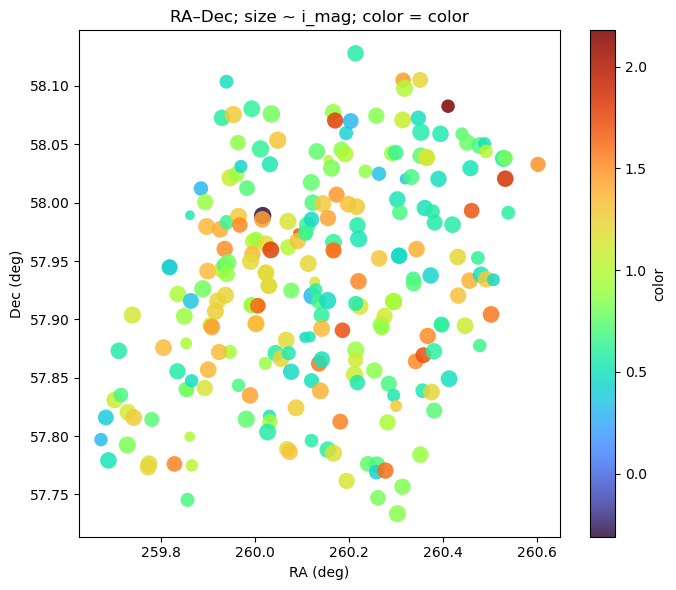

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
csv_path = "output/color_mag.csv"
df = pd.read_csv(csv_path)

# Scale marker sizes from i_mag (linear scaling to visible sizes)
imin, imax = df["i_mag"].min(), df["i_mag"].max()
sizes = 40 + 120 * (df["i_mag"] - imin) / (imax - imin)  # points^2

# Scatter plot
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(df["ra"], df["dec"], s=sizes, c=df["color"], cmap="turbo", vmin=df["color"].min(), vmax=df["color"].max(), alpha=0.85, edgecolors="none")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("color")

ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.set_title("RA–Dec; size ~ i_mag; color = color")
plt.tight_layout()
plt.show()

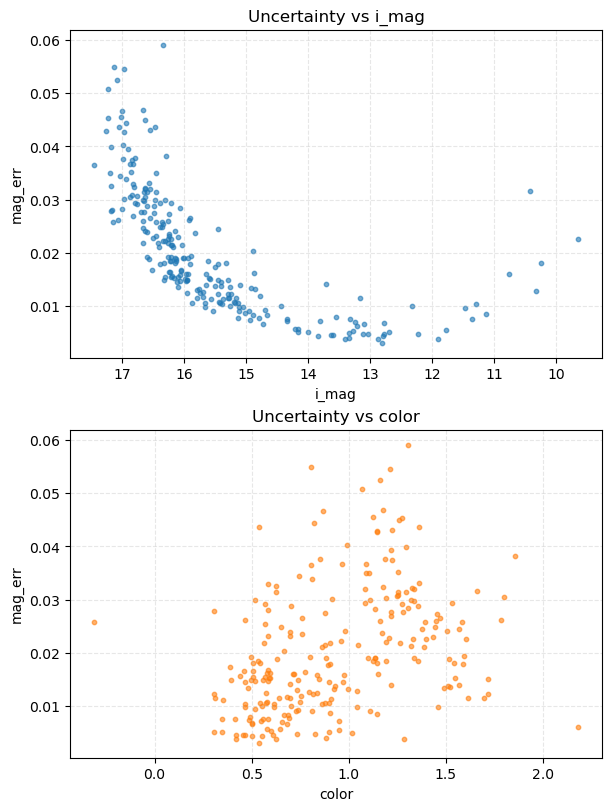

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "output/color_mag.csv"
df = pd.read_csv(csv_path)

# Optional: drop rows with missing values in used columns
df = df.dropna(subset=["i_mag", "color", "mag_err"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharey=True, constrained_layout=True)

# 1) i_mag vs mag_err
ax1.scatter(df["i_mag"], df["mag_err"], s=10, alpha=0.6)
ax1.set_xlabel("i_mag")
ax1.set_ylabel("mag_err")
ax1.set_title("Uncertainty vs i_mag")
ax1.grid(True, ls="--", alpha=0.3)
# Optional for magnitudes: invert X so brighter on the left
ax1.invert_xaxis()

# 2) color vs mag_err
ax2.scatter(df["color"], df["mag_err"], s=10, alpha=0.6, color="tab:orange")
ax2.set_xlabel("color")
ax2.set_ylabel("mag_err")
ax2.set_title("Uncertainty vs color")
ax2.grid(True, ls="--", alpha=0.3)

plt.show()

# Make a CMD with overlays of TRGB identified by different methods

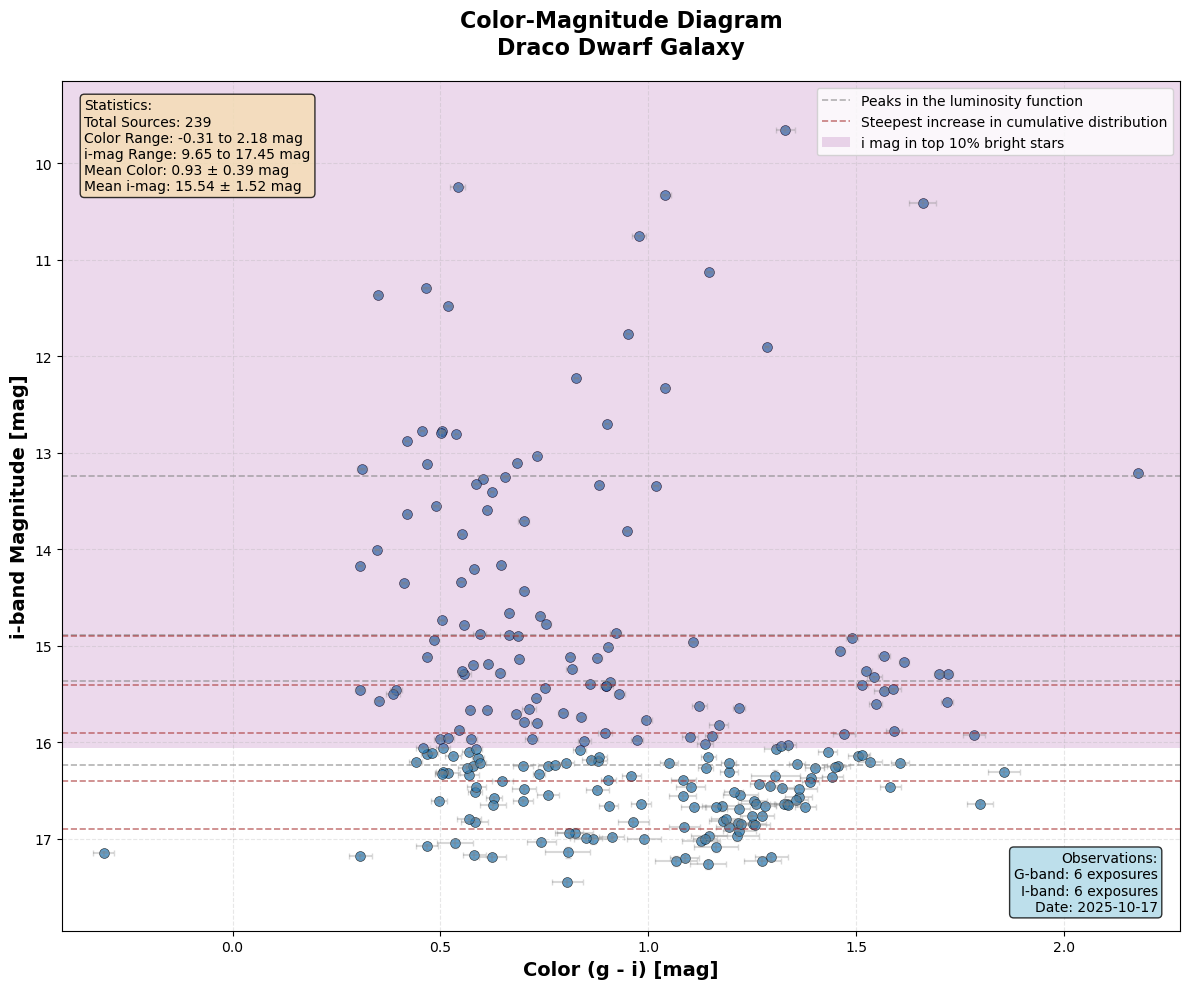

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Create a professional color-magnitude diagram
fig, ax = plt.subplots(figsize=(12, 10))

# Set up the plot with proper astronomical conventions
# In astronomy, magnitude increases downward (fainter objects are higher numbers)
# So we'll invert the y-axis

# Create scatter plot with error bars
scatter = ax.scatter(df['color'], df['i_mag'], 
                    s=50, 
                    alpha=0.7, 
                    edgecolors='black',
                    linewidth=0.5)

# Add error bars
ax.errorbar(df['color'], df['i_mag'], 
           xerr=df['mag_err'], 
           yerr=df['mag_err'],
           fmt='none', 
           alpha=0.3, 
           color='gray',
           capsize=2)

# Customize the plot
ax.set_xlabel('Color (g - i) [mag]', fontsize=14, fontweight='bold')
ax.set_ylabel('i-band Magnitude [mag]', fontsize=14, fontweight='bold')
ax.set_title('Color-Magnitude Diagram\nDraco Dwarf Galaxy', fontsize=16, fontweight='bold', pad=20)

# Invert y-axis (astronomical convention: brighter = lower magnitude)
ax.invert_yaxis()

# Add grid for better readability
ax.grid(True, alpha=0.3, linestyle='--')

# Set axis limits with some padding
ax.set_xlim(df['color'].min() - 0.1, df['color'].max() + 0.1)
ax.set_ylim(df['i_mag'].max() + 0.5, df['i_mag'].min() - 0.5)

# Add statistics text box
stats_text = f"""Statistics:
Total Sources: {len(df)}
Color Range: {df['color'].min():.2f} to {df['color'].max():.2f} mag
i-mag Range: {df['i_mag'].min():.2f} to {df['i_mag'].max():.2f} mag
Mean Color: {df['color'].mean():.2f} ± {df['color'].std():.2f} mag
Mean i-mag: {df['i_mag'].mean():.2f} ± {df['i_mag'].std():.2f} mag"""

# Add text box with statistics
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Add observation details
obs_text = f"""Observations:
G-band: {df['g_key'].nunique()} exposures
I-band: {df['i_key'].nunique()} exposures
Date: 2025-10-17"""

ax.text(0.98, 0.02, obs_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

## METHOD 1. Peaks in luminosity function
# Add horizontal lines at detected peak heights (luminosity peaks)
if len(peaks) > 0:
    for j, ph in enumerate(peak_magnitudes):
        label = 'Peaks in the luminosity function' if j == 0 else None  # single legend entry
        ax.axhline(y=ph, color='gray', linestyle='--', linewidth=1.2, alpha=0.6, label=label)

## METHOD 2. Steepest increase in cumulative distribution
if len(trgb_1_magnitudes) > 0:
    for j, ph in enumerate(trgb_1_magnitudes):
        label = 'Steepest increase in cumulative distribution' if j == 0 else None  # single legend entry
        ax.axhline(y=ph, color='brown', linestyle='--', linewidth=1.2, alpha=0.6, label=label)


## METHOD 3. Brightest 10% of sources
# Shade region where y > trgb_candidate_2 (fainter than TRGB)
y_top = ax.get_ylim()[-1]  # top of plot in data coords after invert_yaxis
ax.axhspan(trgb_candidate_2, y_top, facecolor='purple', alpha=0.15, label='i mag in top 10% bright stars')

plt.legend()

# Improve layout
plt.tight_layout()

# Save the plot
plt.savefig('output/trgb_color_magnitude_diagram.png', dpi=300, bbox_inches='tight')
#plt.savefig('output/trgb_color_magnitude_diagram.pdf', bbox_inches='tight')

# Show the plot
plt.show()
